# **Final Project**

1. Import Packages

In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

2. Select a device

In [2]:
device = torch.device("cuda")

3. Load the images

In [3]:
!git clone https://github.com/ywliu0930/images images

fatal: destination path 'images' already exists and is not an empty directory.


In [4]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    in_transform = transforms.Compose([
                  transforms.Resize(size),
                  transforms.ToTensor(),
                  transforms.Normalize((0.44,0.44,0.44),(0.22,0.22,0.22))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [5]:
content = load_image("/content/images/The Shining.jpg").to(device)
style = load_image('/content/images/OP Art.jpg', shape=content.shape[-2:]).to(device)

4. Reconvert copies of the images to PIL format and display the copies

In [6]:
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.22, 0.22, 0.22)) + np.array((0.44, 0.44, 0.44))
    image = image.clip(0, 1)
    return image

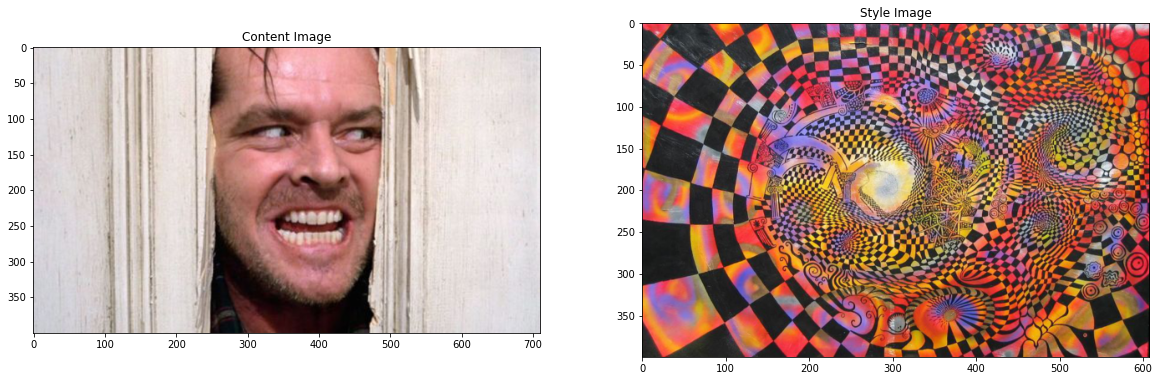

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
plt.show()

5. Import a model (VGG19)

In [8]:
vgg = models.vgg19(pretrained=True).features.to(device)
for param in vgg.parameters():
    param.requires_grad_(False)

6. Get fearutres from the two images

In [9]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  
              '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [10]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


7. Use correlations in different layers to obtain the style related features

In [11]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [12]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

8.  Set the weight of every layer used to obtain style features

In [13]:
style_weights = {'conv1_1': 1.,
          'conv2_1': 0.8,
          'conv3_1': 0.25,
          'conv4_1': 0.21,
          'conv5_1': 0.18}

9. Define the optimizer and the target image which is the copy of content image

In [14]:
target = content.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.003)

10. Start the loss minimization process and show the process every 400 epoch

run 400:
Style Loss : 201926464.000000 Content Loss: 14.350563
Total loss: 201926480.000000


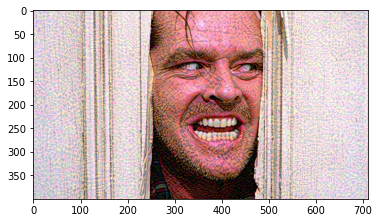

run 800:
Style Loss : 96586792.000000 Content Loss: 15.701848
Total loss: 96586808.000000


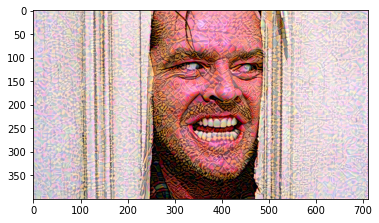

run 1200:
Style Loss : 60141492.000000 Content Loss: 16.423328
Total loss: 60141508.000000


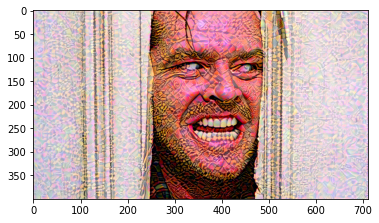

run 1600:
Style Loss : 41198536.000000 Content Loss: 16.945190
Total loss: 41198552.000000


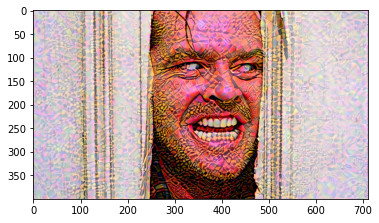

run 2000:
Style Loss : 29889372.000000 Content Loss: 17.323799
Total loss: 29889390.000000


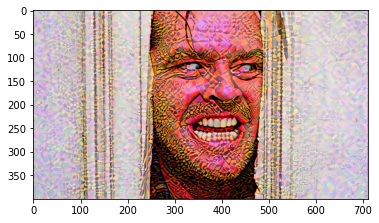

run 2400:
Style Loss : 22492436.000000 Content Loss: 17.616049
Total loss: 22492454.000000


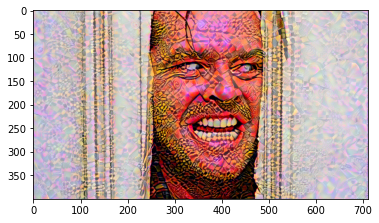

run 2800:
Style Loss : 17300308.000000 Content Loss: 17.843708
Total loss: 17300326.000000


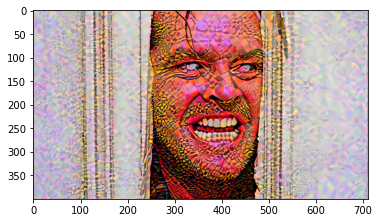

In [15]:
for ii in range(1, 3001):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    content_score = 1 * content_loss
    style_score = 1e6 * style_loss
    total_loss = content_score + style_score
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if ii % 400 == 0:
      print("run {}:".format(ii))
      print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
      print('Total loss: {:4f}'.format(total_loss.item()))
      plt.imshow(im_convert(target))
      plt.show()

11. Display the result

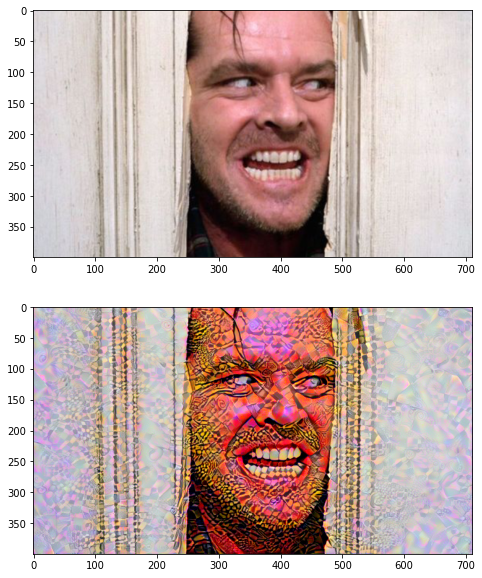

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
plt.show()